In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
def reReadData():
  df=pd.read_csv('gdrive/My Drive/master_ds_v2_NoNA.csv',header=0, index_col=0, 
                infer_datetime_format=True, parse_dates=['Date'])
  df = df.dropna()
  df = df[train_start:test_end]
  df_train, df_test = df[train_start:train_end],df[train_end:test_end]
  return df, df_train, df_test


def plotProb_train(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_train.index, df_train['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_train.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def plotProb_test(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_test.index, df_test['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_test.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def labeling(model,threshold1, threshold2):
  bear_regime = 0 if model.params['const[0]'] < model.params['const[1]'] else 1

  label_filtered = []
  
  for i in model.filtered_marginal_probabilities[bear_regime].values:
    if i >= threshold1:
      app = -1
    elif i >= threshold2:
      app = 0
    else:
      app = 1
    label_filtered.append(app)

  label_filtered= np.array(label_filtered)
  
  return label_filtered


def duration(label):

  duration_bull = []
  duration_static = []
  duration_bear = []

  count,prev,trade = 1,1,0

  for i in label:
    if i == prev:
      count+=1
    else:
      trade+=1
      if prev == 1:
        duration_bull.append(count)
        count = 1
      elif prev == 0:
        duration_static.append(count)
        count = 1
      else:
        duration_bear.append(count)
        count = 1
    prev = i
    
  if prev == 1:
    duration_bull.append(count)
  elif prev == 0:
    duration_static.append(count)
  else:
    duration_bear.append(count)

  duration_bull = pd.DataFrame(duration_bull)
  duration_static = pd.DataFrame(duration_static)
  duration_bear = pd.DataFrame(duration_bear)

  return duration_bull, duration_static, duration_bear,trade


def label_train_logret(label):
  return (df_train['log_ret'] * label).sum()

def label_test_logret(label):
  return (df_test['log_ret'] * label).sum()



def Search_train(model, duration_static, duration_bear):
  threshold1, threshold2, record =0,0,0
  for i in range(1,101):
    for j in range(i):
      label_filtered = labeling(model,i/100, j/100)
      if ( (duration(label_filtered))[1].mean().values >= duration_static ):
        if ( (duration(label_filtered))[2].mean().values >= duration_bear ) :
          if ( (df_train['log_ret'] * label_filtered).sum() >= record ):
            threshold1, threshold2, record = i,j,(df_train['log_ret'] * label_filtered).sum()
  return threshold1/100, threshold2/100



In [4]:
duration_static, duration_bear = 2, 4

## Set time period

In [5]:
train_start = '2010-01-01'
train_end = '2017-12-31'
test_end = '2020-12-31'

## Read data

In [6]:
df,df_train,df_test = reReadData()
print(df,df_train,df_test)

            Russell_Close  ...  hmm1 smoothed state
Date                       ...                     
2010-06-28        2821.11  ...                   -1
2010-06-29        2729.76  ...                   -1
2010-06-30        2703.08  ...                   -1
2010-07-01        2692.74  ...                   -1
2010-07-02        2678.58  ...                   -1
...                   ...  ...                  ...
2020-12-24       12137.42  ...                    1
2020-12-28       12203.97  ...                    1
2020-12-29       12155.89  ...                    1
2020-12-30       12189.07  ...                    1
2020-12-31       12248.16  ...                    1

[2643 rows x 248 columns]             Russell_Close  ...  hmm1 smoothed state
Date                       ...                     
2010-06-28        2821.11  ...                   -1
2010-06-29        2729.76  ...                   -1
2010-06-30        2703.08  ...                   -1
2010-07-01        2692.74  ...       

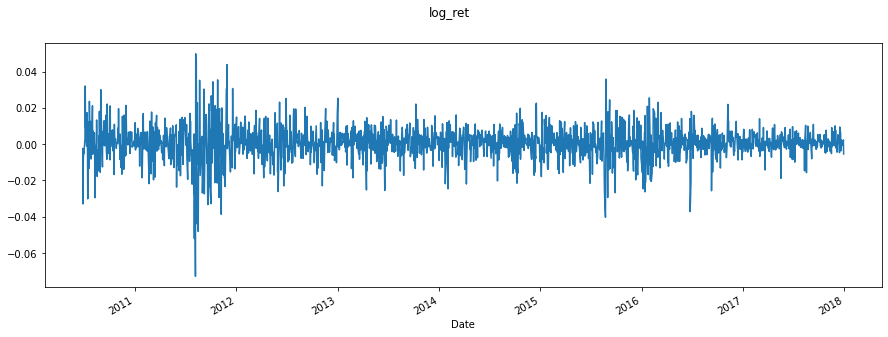

In [7]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('log_ret')
df_train['log_ret'].plot()
plt.show()

In [8]:
k=0
name = 'log_ret_MA'+str(k)
df[name] = df['log_ret']
df = df.dropna()
df = df[train_start:test_end]
df_train, df_test = df[train_start:train_end],df[train_end:test_end]
df

,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,POS_RET,POS_SR,State_RET_shifted,State_SR_shifted,Ret_Russell_Close,Ret_1MTBill,Ret_3MTBill,...,lag80_Ret_WTI_Futures,lag80_Ret_WTI_Spot,lag80_Ret_SP500_Close,lag80_Ret_SP500_Volume,lag100_Ret_Russell_Close,lag100_Ret_1MTBill,lag100_Ret_3MTBill,lag100_Ret_6MTBill,lag100_Ret_1YTBill,lag100_Ret_3YTNotes,lag100_Ret_5YTNotes,lag100_Ret_10YTNotes,lag100_Ret_30YTTreasury,lag100_Ret_T10Y3M,lag100_Ret_T10Y2Y,lag100_Ret_3M_USD_LIBOR,lag100_Ret_WTI_Futures,lag100_Ret_WTI_Spot,lag100_Ret_SP500_Close,lag100_Ret_SP500_Volume,lag120_Ret_Russell_Close,lag120_Ret_1MTBill,lag120_Ret_3MTBill,lag120_Ret_6MTBill,lag120_Ret_1YTBill,lag120_Ret_3YTNotes,lag120_Ret_5YTNotes,lag120_Ret_10YTNotes,lag120_Ret_30YTTreasury,lag120_Ret_T10Y3M,lag120_Ret_T10Y2Y,lag120_Ret_3M_USD_LIBOR,lag120_Ret_WTI_Futures,lag120_Ret_WTI_Spot,lag120_Ret_SP500_Close,lag120_Ret_SP500_Volume,log_ret,hmm1 filtered state,hmm1 smoothed state,log_ret_MA0
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-06-28,2821.11,1.199550e+09,0.063,0.144,0.213,0.280,1.020,1.841,3.047,4.026,2.88,2.43,0.53344,0.36,0.17,78.25,78.15,0.0,540.0,0.0,-0.1,0.0,9.7,0.0,3.0,-0.23,-0.02,-0.77,0.001,123.1971,2.6196,1074.57,3.896410e+09,-1,0,-1,-1,0.002421,-0.111111,-0.069444,...,80.21,80.60,1122.97,3.945010e+09,2834.37,0.043,0.104,0.175,0.315,1.402,2.392,3.680,4.605,3.63,2.85,0.24906,76.98,77.10,1097.28,4.285450e+09,2933.82,0.046,0.071,0.178,0.389,1.567,2.578,3.777,4.620,3.70,2.76,0.25250,81.77,81.47,1136.52,2.491020e+09,-0.002418,1,-1,-0.002418
2010-06-29,2729.76,2.067565e+09,0.061,0.152,0.218,0.280,0.988,1.796,2.986,3.975,2.82,2.36,0.53300,0.38,0.15,75.94,75.44,0.0,540.0,0.0,-0.1,0.0,9.7,0.0,3.0,-3.23,-0.64,-1.29,0.001,119.4815,0.5039,1041.24,6.136700e+09,1,1,-1,-1,0.033464,0.032787,-0.052632,...,81.50,81.79,1138.70,4.133000e+09,2744.50,0.046,0.101,0.172,0.297,1.331,2.323,3.635,4.576,3.53,2.82,0.24875,73.14,73.00,1063.11,5.859690e+09,2937.47,0.023,0.073,0.172,0.394,1.584,2.601,3.809,4.660,3.79,2.84,0.25000,83.18,83.25,1137.14,4.972660e+09,-0.032917,-1,-1,-0.032917
2010-06-30,2703.08,1.775736e+09,0.170,0.188,0.228,0.328,1.020,1.827,2.984,3.946,2.79,2.36,0.53394,0.35,0.09,75.63,75.35,0.0,540.0,0.0,-0.1,0.0,9.7,0.0,3.0,-0.98,0.05,-0.35,0.001,117.9436,-1.7621,1030.71,5.067080e+09,1,1,-1,-1,0.009870,-0.641176,-0.191489,...,81.87,81.80,1138.50,3.774680e+09,2752.57,0.030,0.096,0.157,0.287,1.274,2.258,3.596,4.557,3.49,2.82,0.24969,71.19,71.91,1066.19,6.438900e+09,2949.90,0.028,0.056,0.157,0.382,1.562,2.590,3.812,4.678,3.80,2.82,0.24938,82.66,82.69,1141.69,5.270680e+09,-0.009822,-1,-1,-0.009822
2010-07-01,2692.74,2.018382e+09,0.162,0.177,0.218,0.315,0.972,1.767,2.904,3.851,2.79,2.33,0.53331,0.36,0.17,72.95,72.60,0.0,540.0,0.0,-0.1,0.0,9.7,0.0,3.0,-0.40,-0.31,-0.42,0.001,117.0745,-4.2954,1027.37,6.435770e+09,1,1,-1,-1,0.003840,0.049383,0.062147,...,81.49,81.38,1140.45,5.185570e+09,2729.48,0.035,0.101,0.172,0.297,1.285,2.258,3.593,4.531,3.50,2.83,0.25000,71.89,71.69,1056.74,4.089820e+09,2959.37,0.015,0.053,0.142,0.338,1.550,2.590,3.839,4.723,3.78,2.87,0.25125,82.75,82.91,1144.98,4.389590e+09,-0.003833,-1,-1,-0.003833
2010-07-02,2678.58,1.381267e+09,0.155,0.170,0.221,0.313,0.998,1.796,2.956,3.912,2.83,2.37,0.53363,0.36,0.18,72.14,72.29,1.0,-139.0,0.0,-0.1,1.0,9.5,0.0,3.0,-0.50,-0.30,-0.45,0.001,116.3963,-6.3726,1022.58,3.968500e+09,1,1,0,1,0.005286,0.045161,0.041176,...,82.09,81.98,1145.61,5.469120e+09,2765.58,0.033,0.109,0.183,0.308,1.280,2.252,3.584,4.507,3.55,2.83,0.25000,73.75,73.78,1070.52,5.114260e+09,2963.29,0.018,0.043,0.140,0.313,1.500,2.549

## Three regimes, common variance

In [9]:
hmm0 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=3,trend='c')
hmm0_results = hmm0.fit(search_reps = 100)
print(hmm0_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1478: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1478: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1478: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have bee

                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA0   No. Observations:                 1889
Model:               MarkovRegression   Log Likelihood                6282.988
Date:                Wed, 09 Feb 2022   AIC                         -12545.976
Time:                        03:41:18   BIC                         -12490.538
Sample:                             0   HQIC                        -12525.562
                               - 1889                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0283      0.002    -12.851      0.000      -0.033      -0.024
                             Regime 1 parameters    

Note that the transition prob. from bear to static and from bull to static are too high.

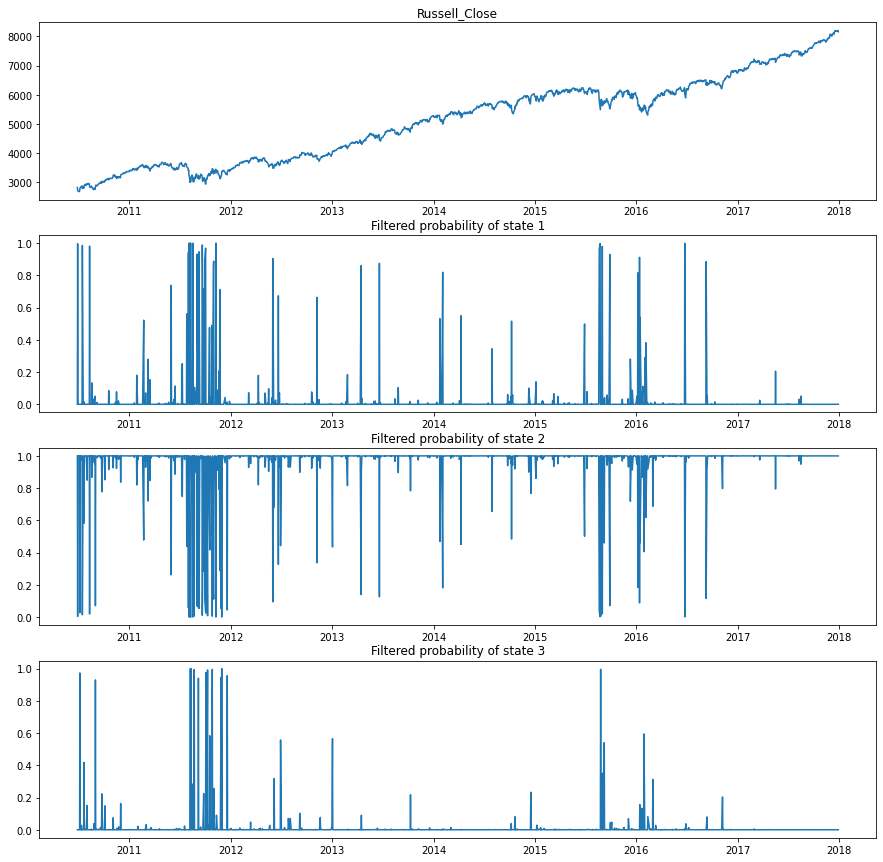

In [10]:
fig, axes = plt.subplots(4, figsize=(15, 15))

ax = axes[0]
ax.plot(df_train.index, df_train['Russell_Close'])
ax.set(title='Russell_Close')
 
ax = axes[1]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[0])
ax.set(title='Filtered probability of state 1')
 
ax = axes[2]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[1])
ax.set(title='Filtered probability of state 2')

ax = axes[3]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[2])
ax.set(title='Filtered probability of state 3')

plt.show()


## Two regimes, switching mean and variance

In [11]:
hmm1 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_results = hmm1.fit(search_reps = 100)
print(hmm1_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA0   No. Observations:                 1889
Model:               MarkovRegression   Log Likelihood                6435.627
Date:                Wed, 09 Feb 2022   AIC                         -12859.254
Time:                        03:41:24   BIC                         -12825.991
Sample:                             0   HQIC                        -12847.005
                               - 1889                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.740      0.459      -0.002       0.001
sigma2         0.0002   1.35e-05     14.211      0.0

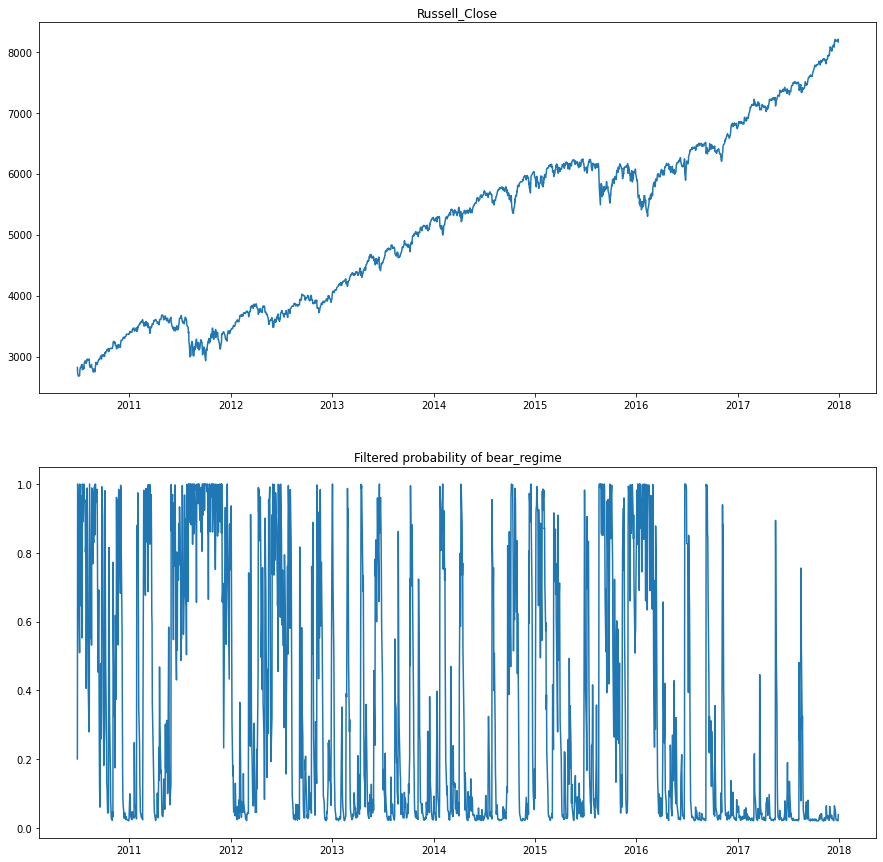

In [12]:
plotProb_train(hmm1_results)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


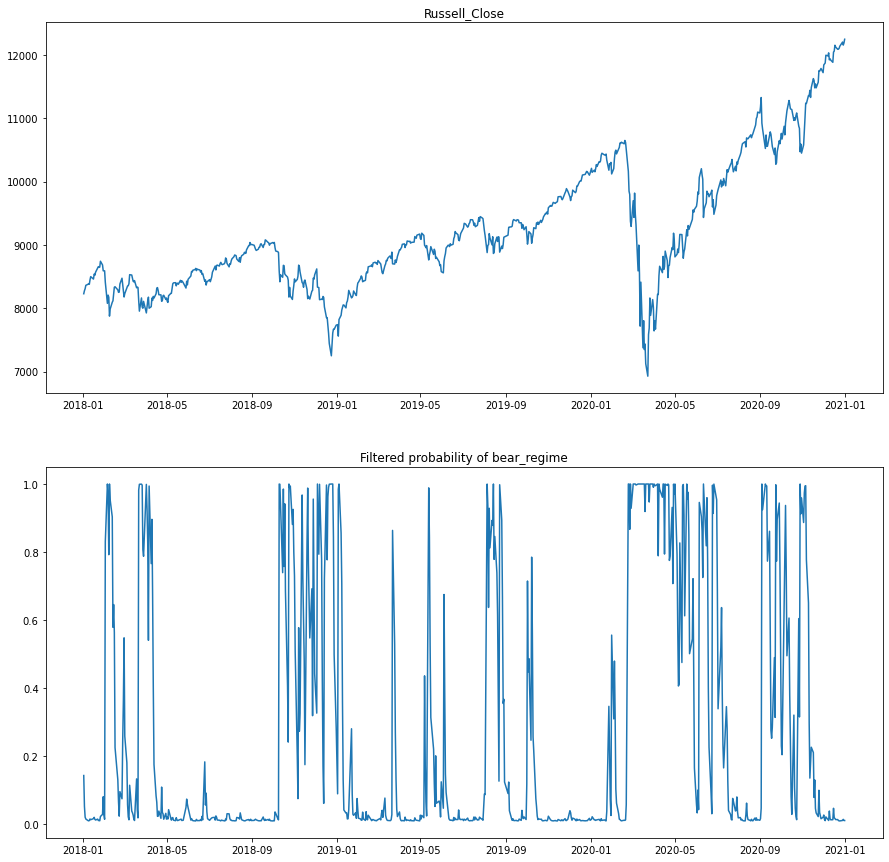

In [13]:
#using the same probability filter constructed from the training set
hmm1_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_test_results = hmm1_test.fit(start_params = hmm1_results.params, maxiter = 0)
plotProb_test(hmm1_test_results)

In [14]:
t1,t2 = Search_train(hmm1_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.74 0.21


In [15]:
label_filtered = labeling(hmm1_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    12.352941
dtype: float64
0    2.260355
dtype: float64
0    4.126126
dtype: float64
364
1.0285128097676428 1.0903551987723756


In [16]:
np.histogram(label_filtered)

(array([ 458,    0,    0,    0,    0,  382,    0,    0,    0, 1049]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

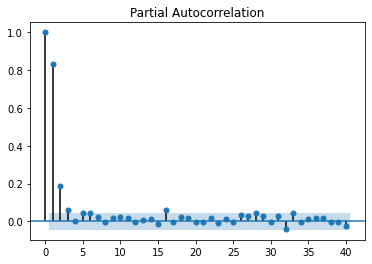

In [17]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()

In [18]:
sm.tsa.pacf(label_filtered)

array([ 1.00000000e+00,  8.32925171e-01,  1.86118030e-01,  5.89330673e-02,
        6.53627988e-04,  4.61084331e-02,  4.17525486e-02,  2.40888722e-02,
       -1.94559894e-03,  1.78969747e-02,  2.26601557e-02,  1.63867861e-02,
       -3.54184852e-03,  5.89301959e-03,  1.41922132e-02, -1.12290298e-02,
        5.80120420e-02, -7.86422123e-04,  2.39163164e-02,  1.68011183e-02,
       -6.56569989e-04, -5.50295929e-03,  1.71173111e-02, -6.46623192e-03,
        1.25185372e-02, -2.49793871e-03,  3.19005303e-02,  2.99773885e-02,
        4.47943179e-02,  2.64429150e-02, -2.08097646e-03,  2.94881503e-02,
       -4.25063291e-02,  4.27428742e-02, -3.48820987e-03,  1.05685874e-02,
        1.92742430e-02,  1.98151633e-02, -2.66773420e-03, -1.65262364e-03,
       -2.30590503e-02])

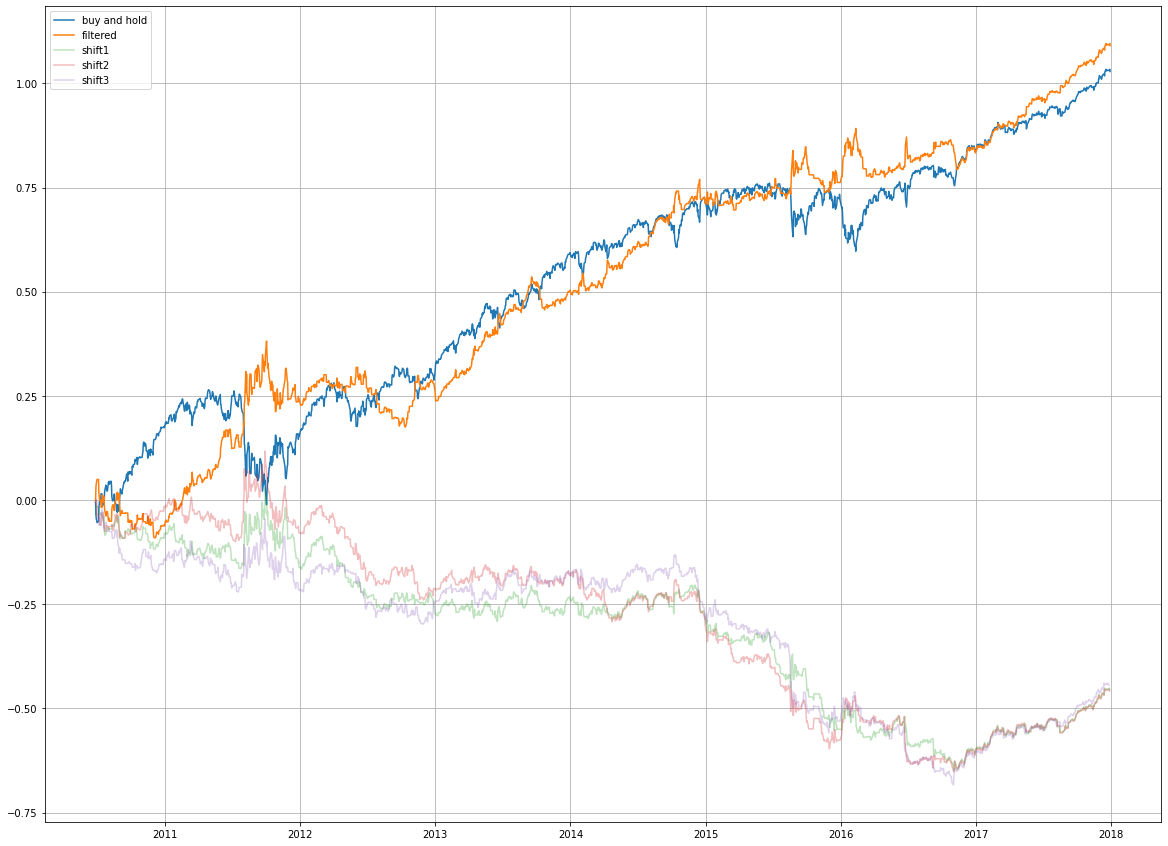

In [19]:
# training set plot

fig, ax = plt.subplots(figsize=(20, 15))

#ax.plot(df_train.index, np.abs(df_train['log_ret']).cumsum(),label="best")
ax.plot(df_train.index, df_train['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_train.index, (df_train['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_train.index, (df_train['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

In [20]:
label_filtered = labeling(hmm1_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    17.5
dtype: float64
0    2.409091
dtype: float64
0    5.3
dtype: float64
101
0.4205309960530377 1.1515288763409741


In [21]:
np.histogram(label_filtered)

(array([159,   0,   0,   0,   0, 106,   0,   0,   0, 489]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

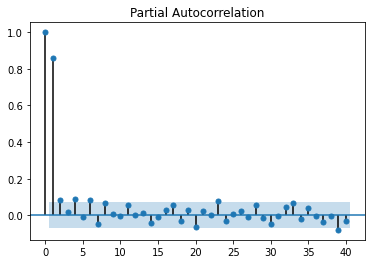

array([ 1.00000000e+00,  8.61507221e-01,  8.63618767e-02,  1.95299324e-02,
        9.15970155e-02, -9.19846757e-03,  8.34128946e-02, -4.67836930e-02,
        6.71676451e-02,  9.65004261e-03, -5.06763552e-03,  5.54931661e-02,
       -4.69002257e-04,  1.15341818e-02, -4.28355025e-02, -7.80729726e-03,
        3.16685027e-02,  5.47114636e-02, -3.31930482e-02,  3.07910560e-02,
       -6.17316582e-02,  2.42272572e-02,  1.37621614e-03,  7.63956686e-02,
       -2.83291065e-02,  7.24664557e-03,  2.28226607e-02, -6.31493710e-03,
        5.64346683e-02, -1.61677985e-02, -4.52134100e-02, -5.69317548e-03,
        4.50822025e-02,  6.63893273e-02, -2.14833312e-02,  4.02762550e-02,
       -6.13380839e-03, -3.42882133e-02, -2.67884806e-03, -7.95155954e-02,
       -3.00994369e-02])

In [22]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

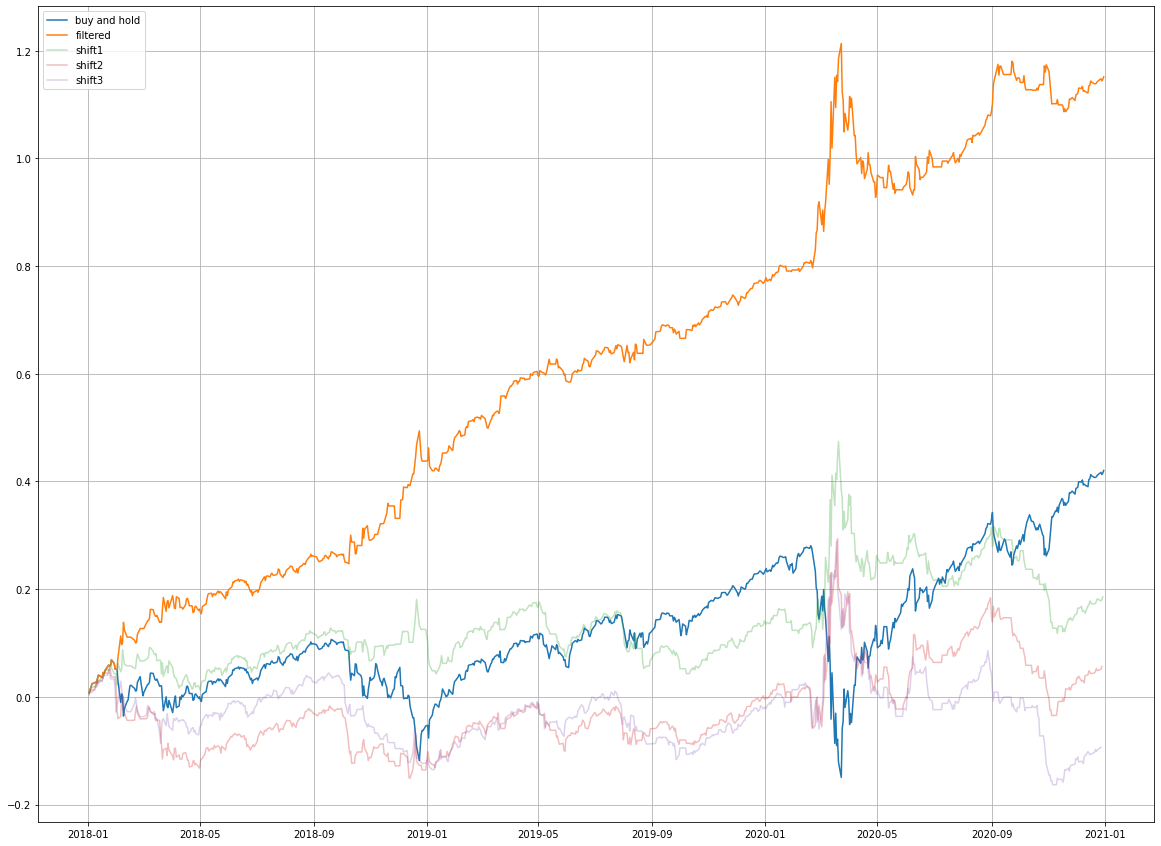

In [23]:
# testing set plot

fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(df_test.index, df_test['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_test.index, (df_test['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_test.index, (df_test['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

## Two regimes, switching mean and variance with other dependent variables in transition prob.

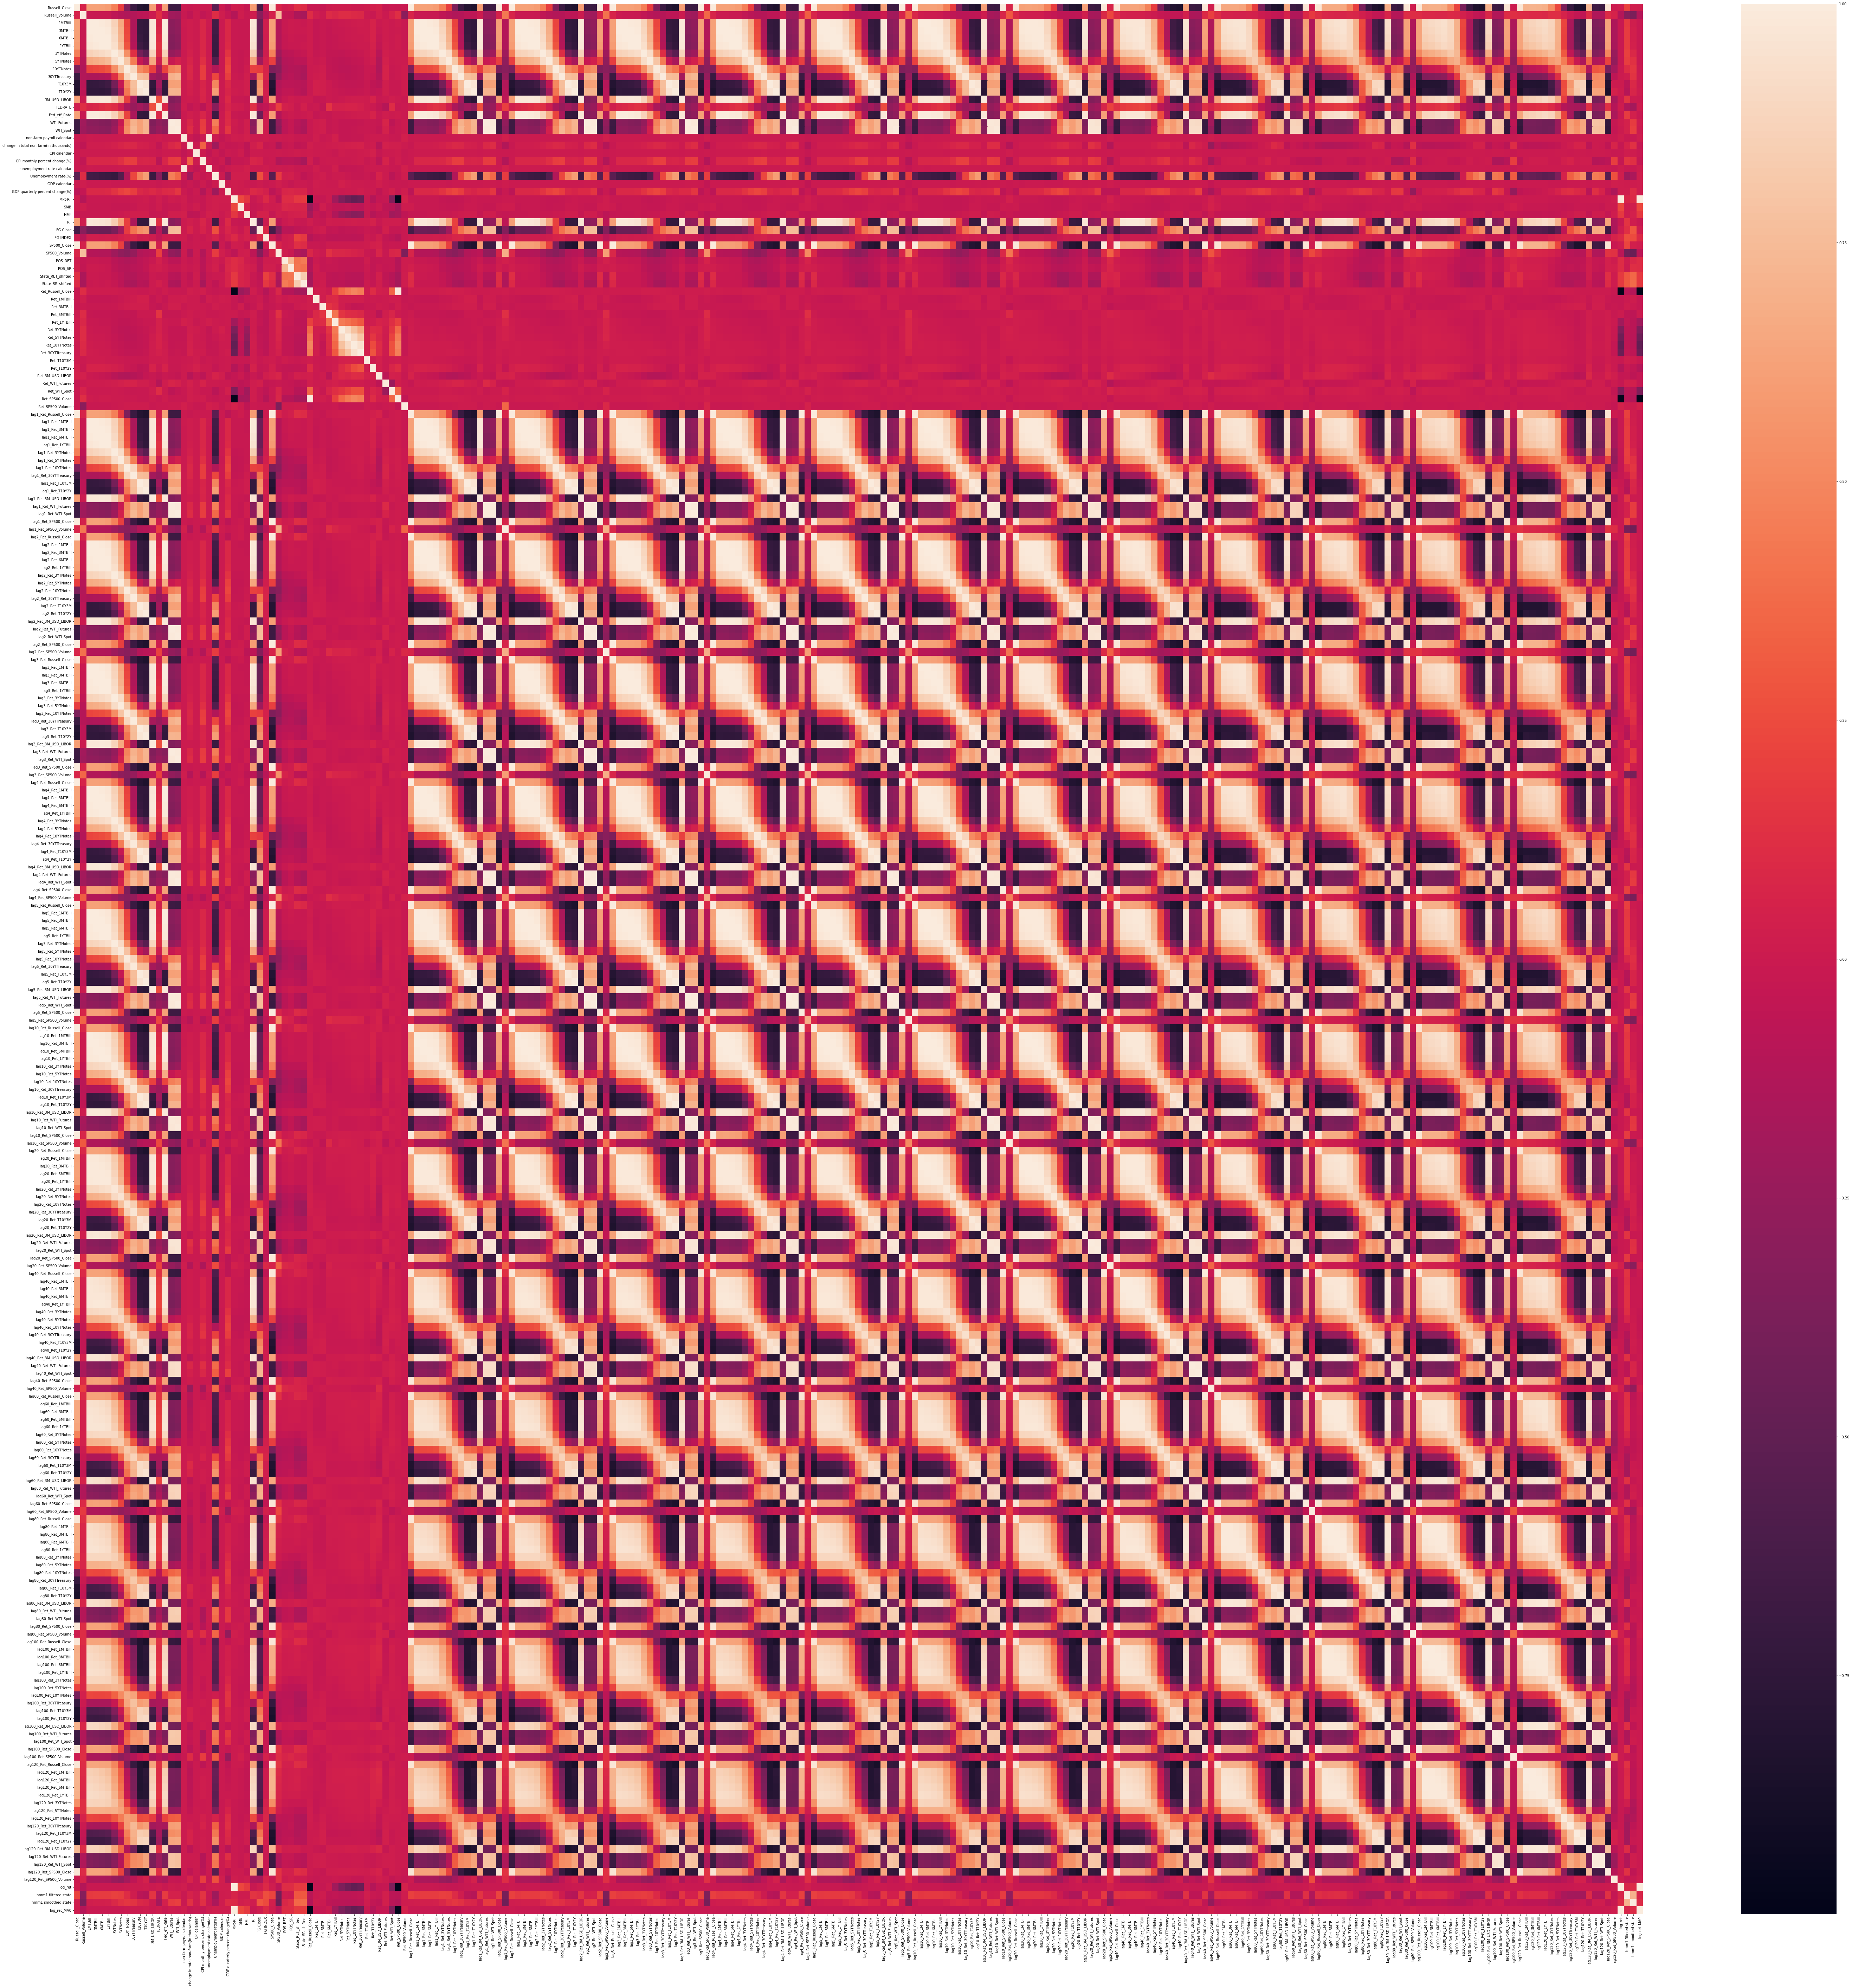

In [24]:
import seaborn as sns
%matplotlib inline

Var_Corr = df.corr()

# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(100,100)) 
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)

In [25]:
for i,j in zip (df[df.columns.to_list()].apply(lambda x: x.autocorr()) , df.columns):
  print(j,i)

Russell_Close 0.9994143005795776
Russell_Volume 0.35022357006060917
1MTBill 0.9994706729513995
3MTBill 0.9997377076548721
6MTBill 0.9997753870869858
1YTBill 0.999710871787978
3YTNotes 0.998696869101453
5YTNotes 0.9975601738979448
10YTNotes 0.9970837509120611
30YTTreasury 0.9975128927493435
T10Y3M 0.9984630256791963
T10Y2Y 0.9989874473860425
3M_USD_LIBOR 0.9998676673369858
TEDRATE 0.9895219691769827
Fed_eff_Rate 0.9991790170023721
WTI_Futures 0.9965185890330666
WTI_Spot 0.9985376195285519
non-farm payroll calendar -0.05007949125596199
change in total non-farm(in thousands) 0.9488653256403777
CPI calendar -0.049662296384584796
CPI monthly percent change(%) 0.9708125039525712
unemployment rate calendar -0.05007949125596199
Unemployment rate(%) 0.9954025071808441
GDP calendar -0.008246770170147787
GDP quarterly percent change(%) 0.9790825757644134
Mkt-RF -0.1467514498948524
SMB -0.05443146372625425
HML 0.05596819839041596
RF 0.9983408797190813
FG Close 0.9965101963679807
FG INDEX 0.9583617

In [26]:
# dependent variables used for transition prob.
# hmm1 smoothed state is not measurable; others contain nan

df_train_tvtp = df_train.drop( columns= ['hmm1 smoothed state','Ret_1MTBill','Ret_T10Y3M', 'Ret_T10Y2Y','POS_RET','POS_SR','State_RET_shifted','State_SR_shifted'])
df_train_tvtp = df_train_tvtp.dropna()

mean,std = df_train_tvtp.mean(),df_train_tvtp.std()

df_train_tvtp = (df_train_tvtp-df_train_tvtp.mean())/df_train_tvtp.std()
df_train_tvtp['ones'] = 1
df_train_tvtp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,Ret_Russell_Close,Ret_3MTBill,Ret_6MTBill,Ret_1YTBill,Ret_3YTNotes,Ret_5YTNotes,Ret_10YTNotes,...,lag80_Ret_WTI_Futures,lag80_Ret_WTI_Spot,lag80_Ret_SP500_Close,lag80_Ret_SP500_Volume,lag100_Ret_Russell_Close,lag100_Ret_1MTBill,lag100_Ret_3MTBill,lag100_Ret_6MTBill,lag100_Ret_1YTBill,lag100_Ret_3YTNotes,lag100_Ret_5YTNotes,lag100_Ret_10YTNotes,lag100_Ret_30YTTreasury,lag100_Ret_T10Y3M,lag100_Ret_T10Y2Y,lag100_Ret_3M_USD_LIBOR,lag100_Ret_WTI_Futures,lag100_Ret_WTI_Spot,lag100_Ret_SP500_Close,lag100_Ret_SP500_Volume,lag120_Ret_Russell_Close,lag120_Ret_1MTBill,lag120_Ret_3MTBill,lag120_Ret_6MTBill,lag120_Ret_1YTBill,lag120_Ret_3YTNotes,lag120_Ret_5YTNotes,lag120_Ret_10YTNotes,lag120_Ret_30YTTreasury,lag120_Ret_T10Y3M,lag120_Ret_T10Y2Y,lag120_Ret_3M_USD_LIBOR,lag120_Ret_WTI_Futures,lag120_Ret_WTI_Spot,lag120_Ret_SP500_Close,lag120_Ret_SP500_Volume,log_ret,hmm1 filtered state,log_ret_MA0,ones
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-06-28,-1.630854,0.299501,-0.423020,-0.226705,-0.223176,-0.259559,0.375040,1.001721,1.590333,1.466945,1.366319,1.302918,0.091875,0.674605,-0.337933,0.129607,0.126141,-0.22361,3.659330,-0.22361,-1.177884,-0.22361,1.685483,-0.182626,0.816714,-0.311861,-0.034928,-1.636652,0.314637,-1.851035,0.506519,-1.683781,0.316674,0.314669,-0.137746,-0.808403,-0.206721,0.768681,0.806711,0.651079,...,0.170219,0.187159,-1.479870,0.233834,-1.511986,-0.462062,-0.259125,-0.231859,-0.018273,1.490956,2.098434,2.371431,2.111964,2.311629,1.856540,-0.717493,0.022036,0.027615,-1.513087,0.615352,-1.415540,-0.440933,-0.395492,-0.191936,0.301945,1.948864,2.435747,2.444931,2.064388,2.347417,1.659683,-0.700340,0.213301,0.200997,-1.392687,-1.504196,-0.319670,0.621231,-0.319670,1
2010-06-29,-1.695277,2.849065,-0.430117,-0.201418,-0.208733,-0.259559,0.293457,0.896335,1.462970,1.376852,1.264187,1.182805,0.090613,0.860056,-0.401896,0.033716,0.013639,-0.22361,3.659330,-0.22361,-1.177884,-0.22361,1.685483,-0.182626,0.816714,-3.552031,-1.233474,-2.748551,0.314637,-2.026924,0.120518,-1.762631,3.325032,3.657276,-0.114507,-0.249421,-0.012282,0.666325,0.687064,0.886485,...,0.224647,0.237380,-1.441228,0.456186,-1.578469,-0.446651,-0.272496,-0.243812,-0.083476,1.296841,1.947958,2.291196,2.065675,2.150420,1.804857,-0.718620,-0.141360,-0.146886,-1.597367,2.471822,-1.412816,-0.572946,-0.385633,-0.217675,0.321194,1.995465,2.484817,2.500337,2.126954,2.490377,1.796861,-0.709921,0.273740,0.277315,-1.391145,1.392287,-3.610547,-1.813427,-3.610547,1
2010-06-30,-1.714093,1.991895,-0.043291,-0.087627,-0.179845,-0.131430,0.375040,0.968935,1.458794,1.325623,1.213122,1.182805,0.093310,0.581879,-0.593786,0.020847,0.009902,-0.22361,3.659330,-0.22361,-1.177884,-0.22361,1.685483,-0.182626,0.816714,-1.121904,0.100392,-0.738580,0.314637,-2.099725,-0.292906,-1.787543,1.888700,1.116761,-0.306433,-0.439381,-2.668042,-0.674825,-0.488745,0.014135,...,0.240259,0.237802,-1.441719,0.032369,-1.572499,-0.528840,-0.294781,-0.303573,-0.119700,1.141002,1.806205,2.221660,2.035348,2.085937,1.804857,-0.715203,-0.224335,-0.193278,-1.589770,3.154873,-1.403536,-0.544247,-0.469438,-0.282022,0.274997,1.935157,2.461349,2.505531,2.155109,2.506262,1.762566,-0.712298,0.251451,0.253305,-1.379830,1.740125,-1.118550,-1.813427,-1.118550,1
2010-07-01,-1.721385,2.704603,-0.071682,-0.122396,-0.208733,-0.166132,0.252665,0.828420,1.291761,1.157804,1.213122,1.131328,0.091502,0.674605,-0.337933,-0.090402,-0.104260,-0.22361,3.659330,-0.22361,-1.177884,-0.22361,1.685483,-0.182626,0.816714,-0.495471,-0.595538,-0.888258,0.314637,-2.14

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(df_train_tvtp)
principalDf_train = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])
principalDf_train

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,-8.384275,13.880630,-1.149357,6.982147,1.147083
1,-8.477373,13.892133,-1.135190,8.636572,8.029015
2,-8.376680,13.470780,-0.706121,9.062731,1.343458
3,-8.343303,13.195076,-0.714579,9.569419,2.905936
4,-8.298854,12.866601,0.030378,10.847442,0.108283
...,...,...,...,...,...
1884,31.596948,9.204645,8.029754,-3.363766,0.566836
1885,31.601764,9.250156,8.137751,-3.738736,0.209241
1886,31.694523,9.428646,7.992179,-4.085390,1.665153
1887,31.830447,9.238465,8.265376,-4.251682,-0.329842


In [28]:
pca.explained_variance_ratio_.sum()

0.8138303533430705

In [29]:
hmm2 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog_tvtp = principalDf_train,
                                    switching_variance=True)
hmm2_results = hmm2.fit(search_reps = 100)
print(hmm2_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA0   No. Observations:                 1889
Model:               MarkovRegression   Log Likelihood                6530.491
Date:                Wed, 09 Feb 2022   AIC                         -13032.983
Time:                        03:42:21   BIC                         -12955.369
Sample:                             0   HQIC                        -13004.402
                               - 1889                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.001     -2.354      0.019      -0.002      -0.000
sigma2         0.0002   1.05e-05     17.063      0.0

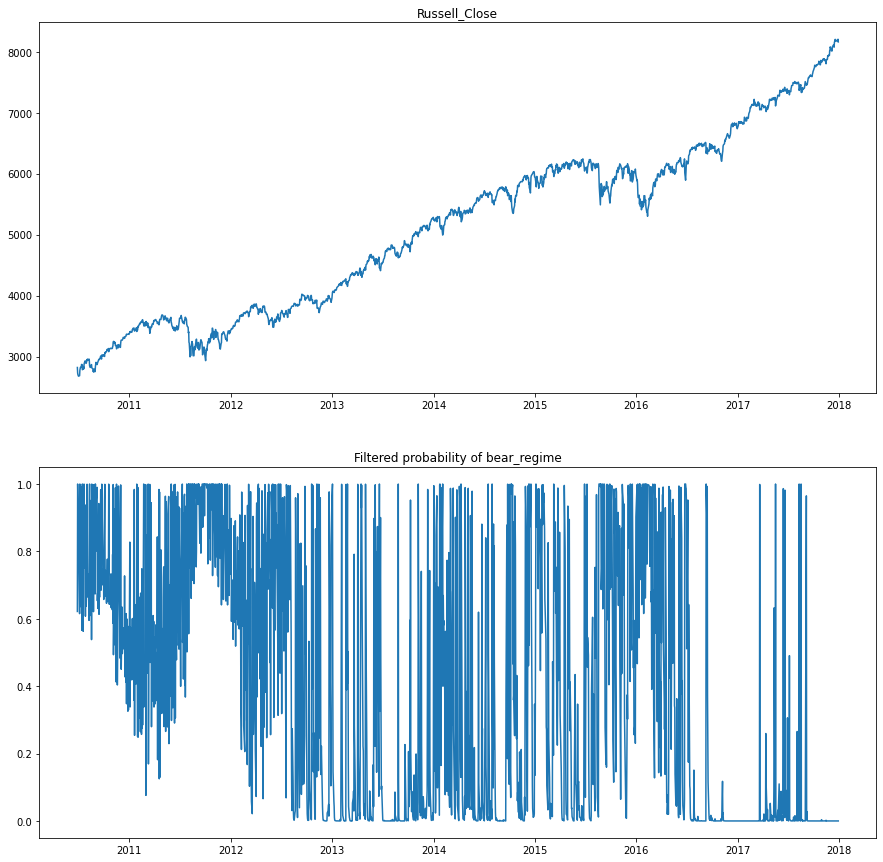

In [30]:
plotProb_train(hmm2_results)

In [31]:
pd.options.mode.use_inf_as_na = True
df_test.columns[df_test.isna().any()].tolist()

['Ret_T10Y3M', 'Ret_T10Y2Y']

In [32]:
df_test_tvtp = df_test.drop( columns= ['hmm1 smoothed state','Ret_1MTBill','Ret_T10Y3M', 'Ret_T10Y2Y','POS_RET','POS_SR','State_RET_shifted','State_SR_shifted'])
df_test_tvtp = df_test_tvtp.dropna()

df_test_tvtp = (df_test_tvtp-mean)/std
df_test_tvtp['ones'] = 1

df_test_tvtp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,Ret_Russell_Close,Ret_3MTBill,Ret_6MTBill,Ret_1YTBill,Ret_3YTNotes,Ret_5YTNotes,Ret_10YTNotes,...,lag80_Ret_WTI_Futures,lag80_Ret_WTI_Spot,lag80_Ret_SP500_Close,lag80_Ret_SP500_Volume,lag100_Ret_Russell_Close,lag100_Ret_1MTBill,lag100_Ret_3MTBill,lag100_Ret_6MTBill,lag100_Ret_1YTBill,lag100_Ret_3YTNotes,lag100_Ret_5YTNotes,lag100_Ret_10YTNotes,lag100_Ret_30YTTreasury,lag100_Ret_T10Y3M,lag100_Ret_T10Y2Y,lag100_Ret_3M_USD_LIBOR,lag100_Ret_WTI_Futures,lag100_Ret_WTI_Spot,lag100_Ret_SP500_Close,lag100_Ret_SP500_Volume,lag120_Ret_Russell_Close,lag120_Ret_1MTBill,lag120_Ret_3MTBill,lag120_Ret_6MTBill,lag120_Ret_1YTBill,lag120_Ret_3YTNotes,lag120_Ret_5YTNotes,lag120_Ret_10YTNotes,lag120_Ret_30YTTreasury,lag120_Ret_T10Y3M,lag120_Ret_T10Y2Y,lag120_Ret_3M_USD_LIBOR,lag120_Ret_WTI_Futures,lag120_Ret_WTI_Spot,lag120_Ret_SP500_Close,lag120_Ret_SP500_Volume,log_ret,hmm1 filtered state,log_ret_MA0,ones
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2.182784,-0.280239,3.800131,3.781256,3.682431,3.800535,2.911766,1.961906,0.370989,-0.672308,-1.799750,-1.940125,3.430079,-0.067200,3.659779,-0.612613,-0.610728,-0.22361,0.098824,-0.22361,0.756077,-0.22361,-1.486330,-0.182626,1.074272,0.854600,0.680334,-0.481988,3.745219,-0.708445,0.227504,2.151675,-0.393905,-0.834241,-0.059381,-0.244232,-0.586640,-0.422045,-0.548479,-0.965515,...,-1.142823,-1.144755,1.817218,-0.465291,1.920541,4.474402,3.943806,3.640672,3.241888,1.767092,0.820480,-0.178240,-0.730802,-1.637976,-1.485613,3.135698,-1.144719,-1.138989,1.882621,-0.537265,1.918638,4.650180,4.376451,3.866232,3.400991,1.866626,0.933788,-0.076065,-0.650982,-1.496619,-1.392517,3.329310,-1.341818,-1.344660,1.856920,-0.709824,0.835042,0.621231,0.835042,1
2018-01-03,2.216706,-0.293652,3.910146,3.755970,3.766205,3.835236,2.911766,1.943170,0.343846,-0.721771,-1.782728,-2.008761,3.427210,0.210977,3.659779,-0.560309,-0.552194,-0.22361,0.098824,-0.22361,0.756077,-0.22361,-1.486330,-0.182626,1.074272,0.573785,-0.730858,-0.375074,3.745219,-0.516731,0.691666,2.192485,-0.163729,-0.571758,-0.033885,-0.206365,-0.142337,-0.014936,0.085804,0.218812,...,-1.210754,-1.210169,1.808202,-0.526133,1.840157,4.505223,3.930435,3.672545,3.260000,1.715145,0.748513,-0.270955,-0.809013,-1.686338,-1.554523,3.135480,-1.185993,-1.188786,1.794296,-0.168138,1.928537,4.696098,4.341943,3.900550,3.462587,1.935157,0.972190,-0.031047,-0.599365,-1.464851,-1.392517,3.328237,-1.316528,-1.316362,1.868310,-0.831151,0.570142,0.621231,0.570142,1
2018-01-04,2.238934,-0.049392,3.839169,3.771774,3.774871,3.864599,2.975503,2.011086,0.350110,-0.720004,-1.748685,-2.008761,3.449819,0.210977,3.659779,-0.544535,-0.547628,-0.22361,0.098824,-0.22361,0.756077,-0.22361,-1.486330,-0.182626,1.074272,0.390175,-0.518212,0.501616,3.745219,-0.371589,1.277611,2.218342,0.046561,-0.354510,-0.046666,-0.058250,-0.121665,-0.272705,-0.371128,-0.069453,...,-1.185860,-1.187801,1.873744,-0.538825,1.848798,4.412761,3.908150,3.620752,3.205664,1.619455,0.687450,-0.281653,-0.789860,-1.670217,-1.520068,3.156888,-1.176207,-1.176869,1.801967,-0.711951,1.952926,4.610002,4.341943,3.879101,3.443338,1.913227,0.923121,-0.051824,-0.594672,-1.480735,-1.392517,3.328237,-1.296811,-1.292352,1.896759,-1.217517,0.351384,0.621231,0.351384,1
2018-01-05,2.276601,-0.418023,3.828522,3.755970,3.751761,3.819220,3.031591,2.041531,0.400220,-0.684674,-1.697619,-1.991602,3.450163,0.396428,3.659779,-0.568196,-0.562988,4.46971,-0.077131,-0.22361,0.756077,4.46971,-1.486330,-0.182626,1.074272,0.649389,-0.672864,-0.524753,3.745219,-0.335867,

In [33]:
principalComponents = pca.transform(df_test_tvtp)
principalDf_test = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])
principalDf_test

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,32.096011,9.181548,8.534784,-3.988115,-1.913612
1,32.304892,9.241049,8.672210,-4.146820,-0.462014
2,32.437384,9.390712,8.652819,-4.173529,-0.293998
3,32.536481,9.594980,8.666626,-4.016056,-0.713565
4,32.680252,9.844423,8.744797,-3.822172,0.098705
...,...,...,...,...,...
749,12.793084,-20.590893,-10.371132,-7.698537,0.069879
750,13.019388,-20.686140,-10.666479,-8.005014,-0.960461
751,13.075608,-20.736938,-10.866193,-7.944414,0.266520
752,12.851061,-20.349295,-10.464836,-8.755758,0.507872


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


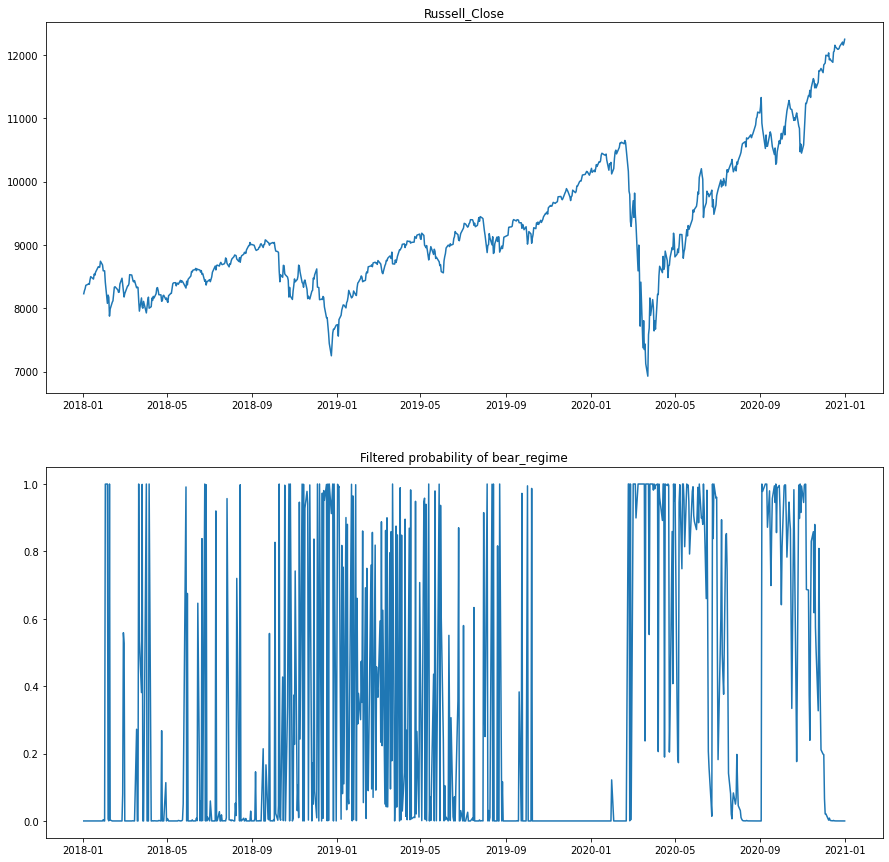

In [34]:
#using the same probability filter constructed from the training set
hmm2_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',exog_tvtp = principalDf_test,
                                    switching_variance=True)
hmm2_test_results = hmm2_test.fit(start_params = hmm2_results.params, maxiter = 0)
plotProb_test(hmm2_test_results)

In [35]:
t1,t2 = Search_train(hmm2_results, duration_static, duration_bear)
print(t1,t2)

0.45 0.01


In [36]:
label_filtered = labeling(hmm2_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    6.172414
dtype: float64
0    2.166008
dtype: float64
0    4.086294
dtype: float64
536
1.0285128097676428 1.6540217013163734


In [37]:
np.histogram(label_filtered)

(array([805,   0,   0,   0,   0, 548,   0,   0,   0, 536]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

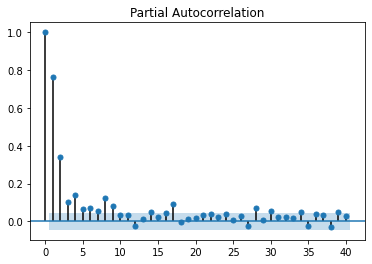

array([ 1.        ,  0.76088346,  0.33812067,  0.10422722,  0.14018601,
        0.06530148,  0.07133662,  0.05560536,  0.12163938,  0.07933922,
        0.03635562,  0.03610366, -0.02298355,  0.01247614,  0.05139559,
        0.02263313,  0.04563437,  0.09144978, -0.00481934,  0.0109939 ,
        0.02039274,  0.0343858 ,  0.03703695,  0.02429632,  0.04103908,
        0.00534054,  0.02744768, -0.0224811 ,  0.06939358,  0.00910928,
        0.05339599,  0.02077141,  0.02563355,  0.0176331 ,  0.05047077,
       -0.02629782,  0.03913027,  0.03201098, -0.02799322,  0.04912193,
        0.02942214])

In [38]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

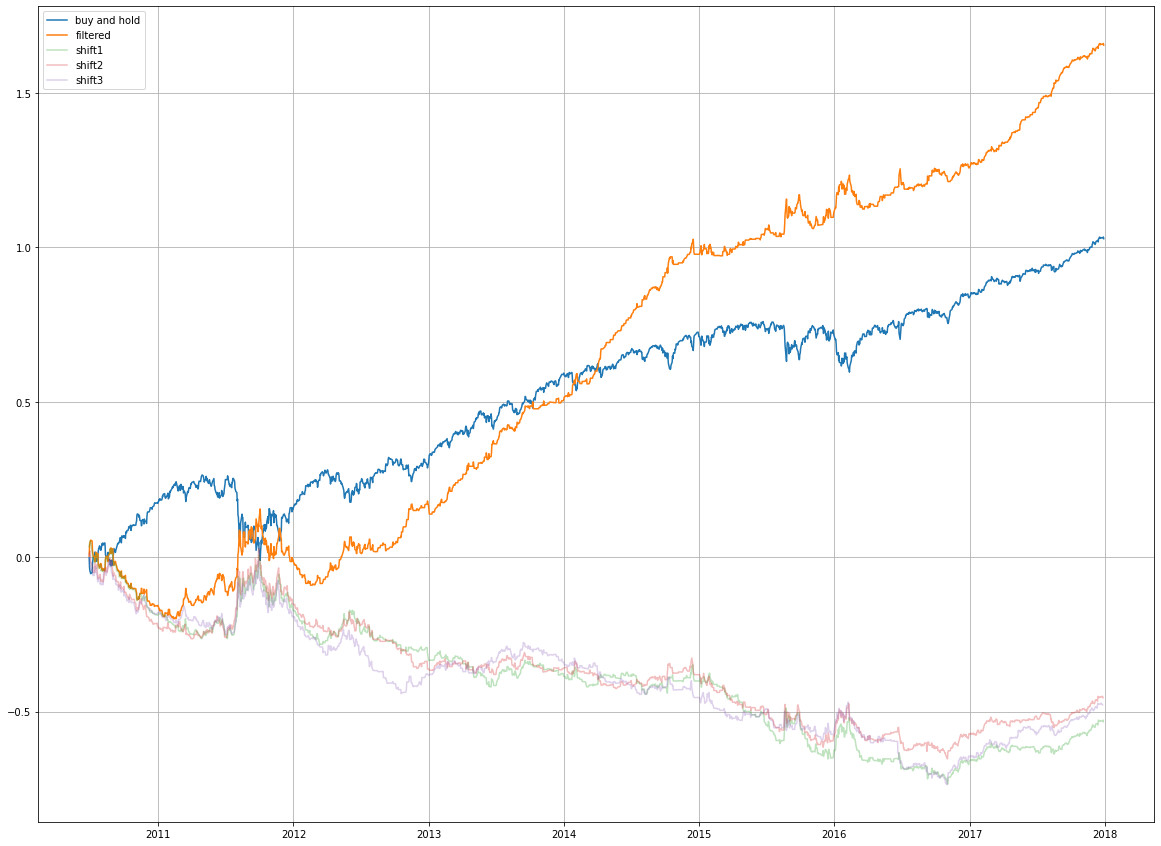

In [39]:
# training set plot

fig, ax = plt.subplots(figsize=(20, 15))

#ax.plot(df_train.index, np.abs(df_train['log_ret']).cumsum(),label="best")
ax.plot(df_train.index, df_train['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_train.index, (df_train['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_train.index, (df_train['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

In [40]:
label_filtered = labeling(hmm2_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    3.969072
dtype: float64
0    1.454545
dtype: float64
0    2.261682
dtype: float64
291
0.4205309960530377 2.1835134956610367


In [41]:
np.histogram(label_filtered)

(array([242,   0,   0,   0,   0, 128,   0,   0,   0, 384]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

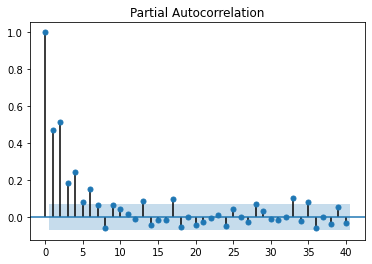

array([ 1.00000000e+00,  4.68865591e-01,  5.15895338e-01,  1.80248069e-01,
        2.42920232e-01,  7.80063913e-02,  1.48232790e-01,  6.47953068e-02,
       -6.26004058e-02,  6.12751483e-02,  4.15968837e-02,  1.61023406e-02,
       -1.37907803e-02,  8.67725574e-02, -4.62207387e-02, -1.97209746e-02,
       -1.78120418e-02,  9.82377336e-02, -5.55792376e-02, -1.77610839e-03,
       -4.23458329e-02, -3.11694693e-02, -7.43365189e-03,  8.91036530e-03,
       -4.86993234e-02,  4.36816032e-02,  6.90539412e-04, -3.01824318e-02,
        6.77269016e-02,  3.03899149e-02, -1.08276516e-02, -1.95932390e-02,
       -9.34866392e-04,  1.02956919e-01, -2.13190366e-02,  8.08643583e-02,
       -6.23936409e-02, -1.14840715e-04, -3.68205794e-02,  5.29781236e-02,
       -3.34232083e-02])

In [42]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

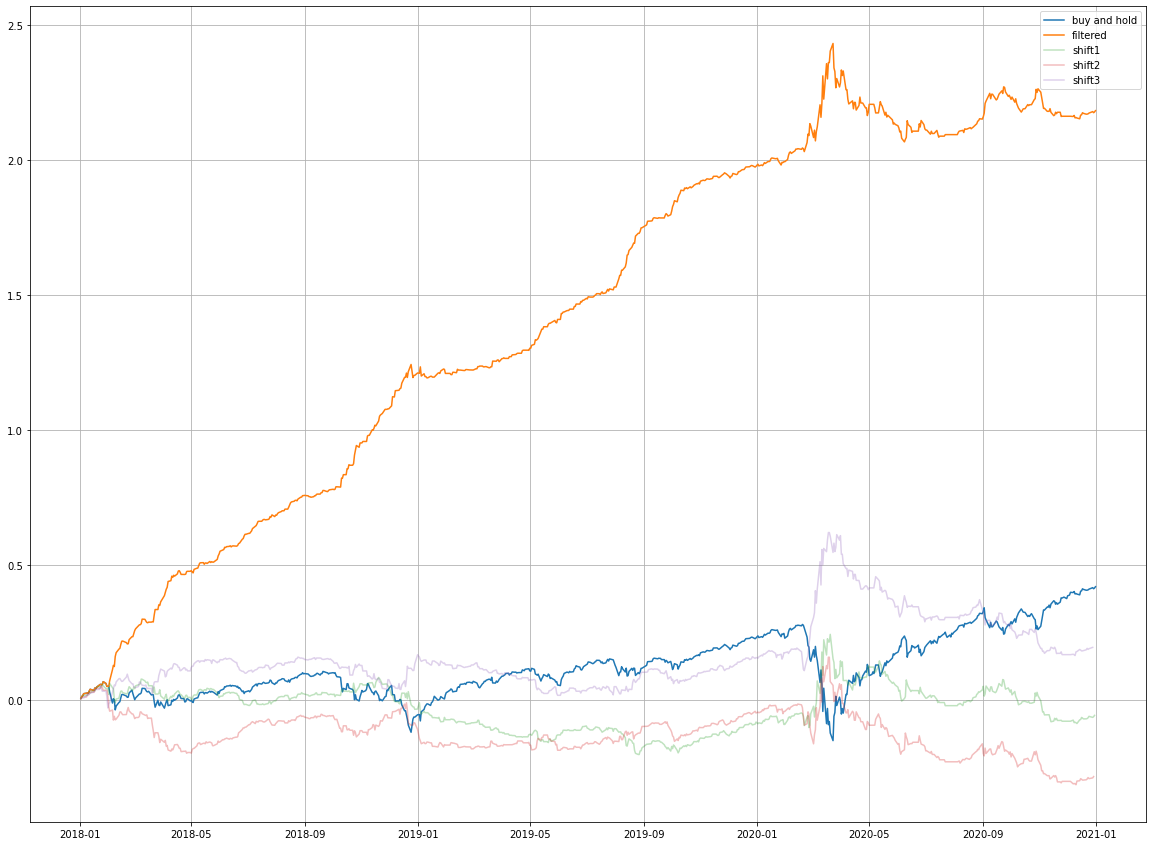

In [43]:
# testing set plot

fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(df_test.index, df_test['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_test.index, (df_test['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_test.index, (df_test['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

## Two regimes, switching mean and variance with other dependent variables in transition prob. and mean.

In [44]:
# switching mean dependent variabels
df_train_exog = df_train[['SMB','HML']]
df_test_exog = df_test[['SMB','HML']]

In [45]:
hmm3 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog = df_train_exog, 
                               exog_tvtp = principalDf_train, switching_exog = True, switching_variance=True)
hmm3_results = hmm3.fit(search_reps = 100)
print(hmm3_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA0   No. Observations:                 1889
Model:               MarkovRegression   Log Likelihood                6699.996
Date:                Wed, 09 Feb 2022   AIC                         -13363.993
Time:                        03:42:55   BIC                         -13264.204
Sample:                             0   HQIC                        -13327.246
                               - 1889                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.000     -0.899      0.369      -0.001       0.000
x1             0.0088      0.001     11.808      0.0

In [46]:
t1,t2 = Search_train(hmm3_results, duration_static, duration_bear)
print(t1,t2)

0.47 0.02


In [47]:
label_filtered = labeling(hmm3_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    5.639535
dtype: float64
0    2.10566
dtype: float64
0    4.014218
dtype: float64
561
1.0285128097676428 1.3646018142770378


In [48]:
np.histogram(label_filtered)

(array([847,   0,   0,   0,   0, 558,   0,   0,   0, 484]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

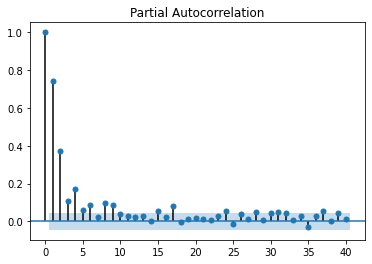

array([ 1.00000000e+00,  7.41888506e-01,  3.71993558e-01,  1.09819686e-01,
        1.69224144e-01,  6.12563717e-02,  8.65021321e-02,  2.41086144e-02,
        9.57798537e-02,  8.58812239e-02,  4.02707440e-02,  3.10174036e-02,
        2.35687347e-02,  2.90776338e-02,  8.55539122e-04,  5.73650202e-02,
        2.53085396e-02,  8.22089404e-02, -5.57363440e-03,  1.52272801e-02,
        1.87012399e-02,  1.38208171e-02,  8.97249342e-03,  2.93503028e-02,
        5.38187782e-02, -1.62880214e-02,  3.74067218e-02,  1.08603200e-02,
        4.76744021e-02,  4.95453203e-03,  4.58295947e-02,  5.14195641e-02,
        4.46236962e-02,  8.47913084e-03,  2.62364176e-02, -2.89723456e-02,
        3.09045086e-02,  5.61190358e-02,  2.99082983e-03,  4.61783440e-02,
        1.33699581e-02])

In [49]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [50]:
hmm3_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c', exog = df_test_exog, 
                               exog_tvtp = principalDf_test, switching_exog = True,switching_variance=True)
hmm3_test_results = hmm3_test.fit(start_params = hmm3_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


In [51]:
label_filtered = labeling(hmm3_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    4.408163
dtype: float64
0    1.493976
dtype: float64
0    2.313953
dtype: float64
266
0.4205309960530377 2.389924155544283


In [52]:
np.histogram(label_filtered)

(array([199,   0,   0,   0,   0, 124,   0,   0,   0, 431]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

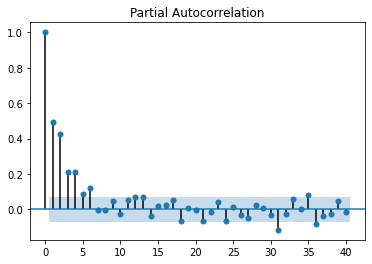

array([ 1.        ,  0.49318635,  0.42489312,  0.20998943,  0.2140169 ,
        0.08896156,  0.11964109, -0.00163598, -0.00567507,  0.04633258,
       -0.02445728,  0.05602292,  0.06835124,  0.06932195, -0.03553425,
        0.02007929,  0.02396401,  0.05085598, -0.06657675,  0.0109642 ,
       -0.00503427, -0.06256999, -0.01613965,  0.04077075, -0.06472583,
        0.01596664, -0.03367063, -0.04856494,  0.02672753,  0.00837137,
       -0.030209  , -0.11531176, -0.02828889,  0.06128503,  0.00236496,
        0.08290629, -0.0806705 , -0.03630023, -0.02751112,  0.04559958,
       -0.01153409])

In [53]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

## Two regimes, switching mean and variance with other dependent variables in mean.

In [54]:
hmm4 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog = df_train_exog, 
                                switching_exog = True,switching_variance=True)
hmm4_results = hmm4.fit(search_reps = 100)
print(hmm4_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA0   No. Observations:                 1889
Model:               MarkovRegression   Log Likelihood                6635.835
Date:                Wed, 09 Feb 2022   AIC                         -13251.670
Time:                        03:43:20   BIC                         -13196.232
Sample:                             0   HQIC                        -13231.256
                               - 1889                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      6.925      0.000       0.001       0.001
x1             0.0051      0.000     15.677      0.0

In [55]:
t1,t2 = Search_train(hmm4_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.78 0.22


In [56]:
label_filtered = labeling(hmm4_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    10.132653
dtype: float64
0    2.316667
dtype: float64
0    4.173913
dtype: float64
392
1.0285128097676428 1.007632080832017


In [57]:
np.histogram(label_filtered)

(array([480,   0,   0,   0,   0, 417,   0,   0,   0, 992]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

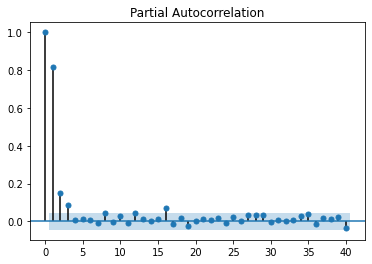

array([ 1.        ,  0.81701922,  0.15042387,  0.08551856,  0.00606596,
        0.01198593,  0.00673771, -0.00758715,  0.04505537, -0.00441643,
        0.02729184, -0.00949578,  0.04356012,  0.01007924,  0.0022201 ,
        0.01337113,  0.06862279, -0.01194055,  0.01666336, -0.02631343,
        0.00143337,  0.01294867,  0.00879212,  0.0165316 , -0.00818348,
        0.02414986,  0.00242558,  0.03620159,  0.03241378,  0.0323724 ,
       -0.00472369,  0.00579053,  0.00428535,  0.00886701,  0.02818012,
        0.04161115, -0.01210373,  0.01874643,  0.01224094,  0.0210159 ,
       -0.03383167])

In [58]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [59]:
hmm4_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c', exog = df_test_exog, 
                                switching_exog = True,switching_variance=True)
hmm4_test_results = hmm4_test.fit(start_params = hmm4_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [60]:
label_filtered = labeling(hmm4_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    15.516129
dtype: float64
0    2.017241
dtype: float64
0    3.925
dtype: float64
128
0.4205309960530377 1.0347690609156968


In [61]:
np.histogram(label_filtered)

(array([157,   0,   0,   0,   0, 117,   0,   0,   0, 480]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

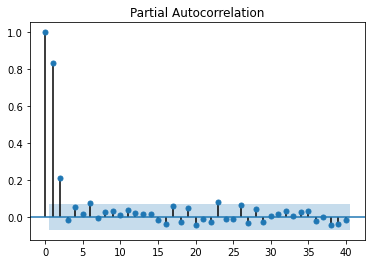

array([ 1.00000000e+00,  8.36003743e-01,  2.09752115e-01, -1.73223798e-02,
        5.53114426e-02,  1.58361530e-02,  7.62657411e-02, -9.20087090e-03,
        2.78414284e-02,  3.28491721e-02,  1.06165127e-02,  3.81227515e-02,
        1.76106395e-02,  1.24726672e-02,  1.66057248e-02, -1.82217084e-02,
       -3.84317629e-02,  6.06022610e-02, -2.66855954e-02,  4.58763018e-02,
       -4.66168005e-02, -1.00492968e-02, -2.68782423e-02,  7.73730226e-02,
       -1.31276398e-02, -1.38703336e-02,  6.11711573e-02, -3.56708019e-02,
        4.34160099e-02, -3.04678701e-02,  5.54450713e-03,  1.47582565e-02,
        3.24256215e-02,  4.78138267e-03,  2.45579513e-02,  3.28629349e-02,
       -2.04411722e-02,  1.99255915e-04, -4.51237219e-02, -3.99690185e-02,
       -2.02296156e-02])

In [62]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [63]:
hmm5 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog = principalDf_train, 
                                switching_exog = True,switching_variance=True)
hmm5_results = hmm5.fit(search_reps = 100)
print(hmm5_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA0   No. Observations:                 1889
Model:               MarkovRegression   Log Likelihood                7901.844
Date:                Wed, 09 Feb 2022   AIC                         -15771.689
Time:                        03:43:47   BIC                         -15682.988
Sample:                             0   HQIC                        -15739.026
                               - 1889                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.000     -2.422      0.015      -0.002      -0.000
x1            -0.0002   5.23e-05     -3.892      0.0

This model labels the observables from a perspective fairly different from bear and bull concept.

In [64]:
t1,t2 = Search_train(hmm5_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.91 0.72


In [65]:
label_filtered = labeling(hmm4_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    12.53211
dtype: float64
0    1.304094
dtype: float64
0    1.941935
dtype: float64
434
1.0285128097676428 1.4270657340205353


In [66]:
np.histogram(label_filtered)

(array([ 301,    0,    0,    0,    0,  223,    0,    0,    0, 1365]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

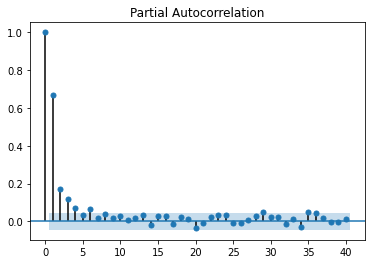

array([ 1.        ,  0.66736935,  0.17022724,  0.11773989,  0.07207656,
        0.03374097,  0.06491244,  0.01529537,  0.03837468,  0.01623631,
        0.03054031,  0.00512987,  0.01745868,  0.03385435, -0.01880003,
        0.02933442,  0.03082932, -0.01351163,  0.02304577,  0.01199934,
       -0.03592468, -0.00950752,  0.02261618,  0.03213653,  0.03251212,
       -0.01072016, -0.00995339,  0.00842159,  0.03097813,  0.04932656,
        0.02139704,  0.02438766, -0.01447548,  0.01320827, -0.02735093,
        0.05144562,  0.04384323,  0.01652716, -0.00535564, -0.00339405,
        0.01270942])

In [67]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [68]:
hmm5_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c', exog = principalDf_test, 
                                switching_exog = True, switching_variance=True)
hmm5_test_results = hmm5_test.fit(start_params = hmm5_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


LinAlgError: ignored

In [ ]:
label_filtered = labeling(hmm4_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

In [ ]:
np.histogram(label_filtered)

In [ ]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

## Method 1
## Pick thresholds such that the durations meet certain criteria

In [ ]:
## some tech issue for this function

#from scipy.optimize import minimize
def FindTresholds(model_train):
  threshold1,threshold2 = 70,30
  label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
  duration_bear = duration(label)
  duration_bear_mean = duration_bear.mean()
    
  #find threshold1 such that the bear duration reach 4
  while(duration_bear_mean <=4 and threshold1 <=99):
    threshold1+=1
    label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
    duration_bear = duration(label)
    duration_bear_mean = duration_bear.mean()
    
  #find threshold2 that maximizes log return
  #logret_prev = label_logret(label_train_filtered)
  #for threshold2 in range(30,threshold1):
  #  label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
  #  logret = logret(label_train_filtered)
  #  if logret < logret_prev:
  #    threshold2-=1
  #    break
  #  logret_prev = logret

  return threshold1/100,threshold2/100


In [ ]:
label_filtered = labeling(hmm1_results,0.99,0.89)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

In [ ]:
np.histogram(label_filtered)

In [ ]:
label_filtered = labeling(hmm1_test_results,0.99,0.89)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

In [ ]:
np.histogram(label_filtered)

In [ ]:
label_filtered = labeling(hmm2_results,0.99, 0.45)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

In [ ]:
np.histogram(label_filtered)

In [ ]:
label_filtered = labeling(hmm2_test_results,0.99, 0.45)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

In [ ]:
np.histogram(label_filtered)

In [ ]:
label_filtered = labeling(hmm3_results,0.99, 0.71)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

In [ ]:
np.histogram(label_filtered)

In [ ]:
label_filtered = labeling(hmm3_test_results,0.99, 0.71)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

In [ ]:
np.histogram(label_filtered)

In [ ]:
label_filtered = labeling(hmm4_results,0.99, 0.91)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

In [ ]:
np.histogram(label_filtered)

In [ ]:
label_filtered = labeling(hmm4_test_results,0.99, 0.91)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

In [ ]:
np.histogram(label_filtered)